Fetching files from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/USV_Project_2021/E:/

# old location - saved for documentation
#%cd /content/drive/Shareddrives/TEST_RECORDINGS/Final_Project/E:/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZAaPx3ZyueNJEhIpm0_6D9KpkprurC0K/E:


Importing libraries

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pyplot as plt
%pip install tensorflow==2.4
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
import random
from tensorflow.keras import layers, models
from tensorflow.keras.layers import UpSampling2D,Input,LeakyReLU,MaxPooling2D,Dropout,Lambda,add,Activation,Concatenate,Dense,Flatten,Conv2D
#from keras.utils import plot_model
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


     |████████████████████████████████| 394.7 MB 7.6 kB/s 
     |████████████████████████████████| 3.8 MB 28.6 MB/s 
     |████████████████████████████████| 462 kB 53.9 MB/s 
     |████████████████████████████████| 2.9 MB 33.3 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.41.0
    Uninstalling grpcio-1.41.0:
      Successfully uninstalled grpcio-1.41.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6

Functions Definitions

In [17]:
def Take_Syllables(Syllable_name,Data,Labels):
    ind = Labels == Syllable_name
    Syllables = Data[ind]
    return Syllables

def set_callbacks( name = 'best_model_weights',patience=8,tb_base_logdir='./logs/'):
    from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
    cp = ModelCheckpoint(name +'.h6',save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)
    return [rlop, es, cp]

def print_loss(hist):
    plt.figure()
    plt.plot(hist.history['loss'], 'r', hist.history['val_loss'], 'b')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Model loss function', fontsize=18)
    plt.legend(['Training loss','Validation loss'])
    plt.savefig('loss_poster_drop')
    plt.figure()
    plt.plot(hist.history['accuracy'], 'r', hist.history['val_accuracy'], 'b')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Model accuracy', fontsize=18)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.savefig('acc_poster_drop')

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,5),filename = None,annot_kws={"size": 20}, cmap=None):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    # Adjust to fit
    label_font = {'size':'18'}
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);
    sns.heatmap(cm, annot=annot, cmap=cmap, fmt='', ax=ax,annot_kws=annot_kws)
    # fig.savefig('/content/drive/Shareddrives/USV_Project_2021/E:/new')
    fig.savefig('/content/drive/Shareddrives/USV_Project_2021/E:/141021_results')

    if filename is not None:
       plt.savefig(filename)

Loading Data

/content/drive/.shortcut-targets-by-id/1ZAaPx3ZyueNJEhIpm0_6D9KpkprurC0K/E:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


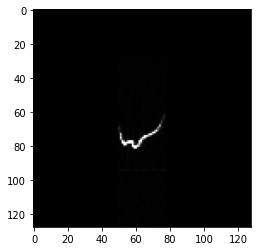

In [4]:
#img_rows, img_cols = 64, 64 #choosing resize values
%cd /content/drive/Shareddrives/USV_Project_2021/E:/
Data_united = np.load('Data_united_128.npy',allow_pickle = True)
Labels_united = np.load('Labels_united_18072021.npy',allow_pickle = True)


#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#Data_united = np.array([scaler.fit_transform(i) for i in Data_united])
#for i in range(len(Data_united)):
#  Data_united[i] = 20*np.log10(Data_united[i])
#Data_united = 20*np.log10(Data_united)

Data_united = np.repeat(Data_united[:, :, :, np.newaxis], 3, -1)
plt.imshow(Data_united[7])
Complex_syl = Take_Syllables('Complex',Data_united,Labels_united)
Frequency_steps_syl = Take_Syllables('Frequency Steps',Data_united,Labels_united)
Chevron_syl = Take_Syllables('Chevron',Data_united,Labels_united)
Composite_syl = Take_Syllables('Composite',Data_united,Labels_united)
Noise_syl = Take_Syllables('99.0',Data_united,Labels_united)
two_syllable_syl = Take_Syllables('Two-Syllable',Data_united,Labels_united)
upward_syl = Take_Syllables('Upward',Data_united,Labels_united)
flat_syl = Take_Syllables('Flat',Data_united,Labels_united)
short_syl = Take_Syllables('Short',Data_united,Labels_united)
harmonics_syl = Take_Syllables('Harmonics',Data_united,Labels_united)
downward_syl = Take_Syllables('Downward',Data_united,Labels_united)

del Data_united



In [5]:
complex_Labels = np.zeros((len(Complex_syl)))
freq_Labels = np.ones((len(Frequency_steps_syl)))
composite_Labels = 2*np.ones((len(Composite_syl)))
#Noise_Labels = 3*np.ones((len(Noise_syl)))
Two_Labels = 3*np.ones((len(two_syllable_syl)))
up_Labels = 4*np.ones((len(upward_syl)))
flat_Labels = 5*np.ones((len(flat_syl)))
harmo_Labels = 6*np.ones((len(harmonics_syl)))
down_Labels = 7*np.ones((len(downward_syl)))
chev_Labels = 8*np.ones((len(Chevron_syl)))
short_Labels = 9*np.ones((len(short_syl)))

Data = np.concatenate((Complex_syl, Frequency_steps_syl, Composite_syl, two_syllable_syl, upward_syl, flat_syl, harmonics_syl, downward_syl, Chevron_syl, short_syl))
Labels = np.concatenate((complex_Labels, freq_Labels, composite_Labels, Two_Labels, up_Labels, flat_Labels, harmo_Labels, down_Labels, chev_Labels, short_Labels))

from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(Data, Labels, test_size=0.1, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.13, random_state=42)
train_images = train_images.astype('float32')
train_images = train_images/255
val_images = val_images.astype('float32')
val_images = val_images/255
test_images = test_images.astype('float32')
test_images = test_images/255

del Data
del Labels

In [6]:
tot = len(Complex_syl) + len(Frequency_steps_syl) + len(Composite_syl) + len(flat_syl) + len(harmonics_syl) + len(Chevron_syl) + len(short_syl) + len(two_syllable_syl) + len(downward_syl) + len(upward_syl)
Complex_weight = (1/len(Complex_syl))*(tot)/10
Frequency_weight = (1/len(Frequency_steps_syl))*(tot)/10
Composite_weight = (1/len(Composite_syl))*(tot)/10
#Noise_weight = (1/len(Noise_syl))*(tot)/10
Two_weight = (1/len(two_syllable_syl))*(tot)/10
up_weight = (1/len(upward_syl))*(tot)/10
flat_weight = (1/len(flat_syl))*(tot)/10
harmo_weight = (1/len(harmonics_syl))*(tot)/10
down_weight = (1/len(downward_syl))*(tot)/10
chev_weight = (1/len(Chevron_syl))*(tot)/10
short_weight = (1/len(short_syl))*(tot)/10

class_weight = {0:Complex_weight, 1:Frequency_weight, 2:Composite_weight, 3:Two_weight, 4:up_weight, 5:flat_weight, 6:harmo_weight, 7:down_weight, 8:chev_weight, 9:short_weight}
print(class_weight)


{0: 0.9107476635514018, 1: 0.2917664670658683, 2: 0.6128930817610063, 3: 1.402158273381295, 4: 1.8300469483568076, 5: 3.4803571428571423, 6: 2.4670886075949365, 7: 7.9551020408163255, 8: 0.8020576131687243, 9: 1.9297029702970296}


In [7]:
feature_extractor_model = "https://tfhub.dev/google/bit/m-r50x3/1"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, trainable=False)


In [8]:
#model = tf.keras.Sequential([
#                             feature_extractor_layer,
#                             tf.keras.layers.Dense(64, activation='relu'), 
#                             tf.keras.layers.Dense(4)
#])
#model.build([None, 64, 64, 3])

inputs = Input(shape=(128, 128, 3))
#x = tf.keras.layers.experimental.preprocessing.Resizing(96, 96)(inputs)
x = feature_extractor_layer(inputs, training=False)
#x = tf.keras.layers.Dense(2048, activation='relu')(x)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.3)(x)
#x = tf.keras.layers.Dense(64, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.3)(x)
x = Dropout(0.9)(x)
#x = Dense(128)(x)
#x = LeakyReLU(alpha=0.2)(x)
#x = Dropout(0.2)(x)
#x = Dense(16)(x)
outputs = Dense(10, activation='softmax')(x)
model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)

Data Augmentetion

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        zoom_range = [0.9, 1.],
   #     brightness_range = [0.995, 1.005],
        fill_mode='nearest')

In [10]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
batch_size = 128
model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
          steps_per_epoch=len(train_images)/batch_size, validation_data = (val_images,val_labels),
                 shuffle=True, epochs=5 ,class_weight=class_weight,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))
# previously - epochs = 200 -> 20

Epoch 1/5
23/23 [==============================] - 126s 3s/step - loss: 9.1852 - accuracy: 0.1378 - val_loss: 2.2979 - val_accuracy: 0.3457
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 2/5
23/23 [==============================] - 66s 3s/step - loss: 7.1056 - accuracy: 0.2001 - val_loss: 2.1909 - val_accuracy: 0.3873
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 3/5
23/23 [==============================] - 66s 3s/step - loss: 5.9075 - accuracy: 0.2085 - val_loss: 2.0388 - val_accuracy: 0.3348
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 4/5
23/23 [==============================] - 66s 3s/step - loss: 5.3968 - accuracy: 0.2160 - val_loss: 2.1824 - val_accuracy: 0.3698
Epoch 5/5
23/23 [==============================] - 66s 3s/step - loss: 4.6850 - accuracy: 0.2340 - val_loss: 2.1803 - val_accuracy: 0.3370


In [11]:
model.evaluate(test_images, test_labels, verbose=2)

13/13 - 11s - loss: 2.1715 - accuracy: 0.2974


[2.171475648880005, 0.2974359095096588]

In [12]:
feature_extractor_layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
batch_size = 16
steps_per_epoch = len(train_images)/batch_size
#steps_per_epoch = 10
hist = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
          steps_per_epoch=steps_per_epoch, validation_data = (val_images,val_labels),
                 shuffle=True, epochs=20 ,class_weight=class_weight,
                 callbacks = set_callbacks(patience=20,name = 'model_weights'))
# previously - epochs = 36 -> 20

Epoch 1/20
190/190 [==============================] - 318s 2s/step - loss: 4.2203 - accuracy: 0.1886 - val_loss: 1.5539 - val_accuracy: 0.4354
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 2/20
190/190 [==============================] - 302s 2s/step - loss: 2.2630 - accuracy: 0.2581 - val_loss: 1.4777 - val_accuracy: 0.5033
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 3/20
190/190 [==============================] - 301s 2s/step - loss: 1.9223 - accuracy: 0.3608 - val_loss: 1.3830 - val_accuracy: 0.5646
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 4/20
190/190 [==============================] - 302s 2s/step - loss: 1.4664 - accuracy: 0.4769 - val_loss: 1.0796 - val_accuracy: 0.6433
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 5/20
190/190 [==============================] - 302s 2s/step - loss: 1.1510 - accuracy: 0.6048 - val_loss: 1.0132 - val_accuracy: 0.6783
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 6/20
190/190 [==============================] - 302s 2s/step - loss: 0.9714 - accuracy: 0.6518 - val_loss: 0.7791 - val_accuracy: 0.7702
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 7/20
190/190 [==============================] - 302s 2s/step - loss: 0.8915 - accuracy: 0.6947 - val_loss: 0.8091 - val_accuracy: 0.7571
Epoch 8/20
190/190 [==============================] - 302s 2s/step - loss: 0.6792 - accuracy: 0.7515 - val_loss: 0.6544 - val_accuracy: 0.7702
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 9/20
190/190 [==============================] - 302s 2s/step - loss: 0.6679 - accuracy: 0.7743 - val_loss: 0.6972 - val_accuracy: 0.7812
Epoch 10/20
190/190 [==============================] - 302s 2s/step - loss: 0.6386 - accuracy: 0.7888 - val_loss: 0.6646 - val_accuracy: 0.7899
Epoch 11/20
190/190 [==============================] - 302s 2s/step - loss: 0.5299 - accuracy: 0.8040 - val_loss: 0.6980 - val_accuracy: 0.7702
Epoch 12/20
190/190 [==============================] - 302s 2s/step - loss: 0.4813 - accuracy: 0.8247 - val_loss: 0.7237 - val_accuracy: 0.7943
Epoch 13/20
190/190 [==============================] - 302s 2s/step - loss: 0.5429 - accuracy: 0.8175 - val_loss: 0.5583 - val_accuracy: 0.8228
INFO:tensorflow:Assets written to: model_weights.h6/assets


INFO:tensorflow:Assets written to: model_weights.h6/assets


Epoch 14/20
190/190 [==============================] - 302s 2s/step - loss: 0.4237 - accuracy: 0.8488 - val_loss: 0.6333 - val_accuracy: 0.8228
Epoch 15/20
190/190 [==============================] - 302s 2s/step - loss: 0.3788 - accuracy: 0.8715 - val_loss: 0.6065 - val_accuracy: 0.8293
Epoch 16/20
190/190 [==============================] - 302s 2s/step - loss: 0.4100 - accuracy: 0.8491 - val_loss: 0.7673 - val_accuracy: 0.8053
Epoch 17/20
190/190 [==============================] - 301s 2s/step - loss: 0.3800 - accuracy: 0.8656 - val_loss: 0.5800 - val_accuracy: 0.8293
Epoch 18/20
190/190 [==============================] - 302s 2s/step - loss: 0.2973 - accuracy: 0.8943 - val_loss: 0.6505 - val_accuracy: 0.8271
Epoch 19/20
190/190 [==============================] - 302s 2s/step - loss: 0.2387 - accuracy: 0.8914 - val_loss: 0.5832 - val_accuracy: 0.8359
Epoch 20/20
190/190 [==============================] - 302s 2s/step - loss: 0.1966 - accuracy: 0.9223 - val_loss: 0.6088 - val_accuracy:

13/13 - 9s - loss: 0.8354 - accuracy: 0.7923


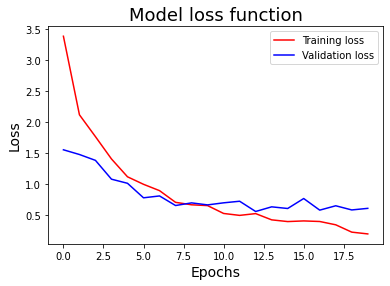

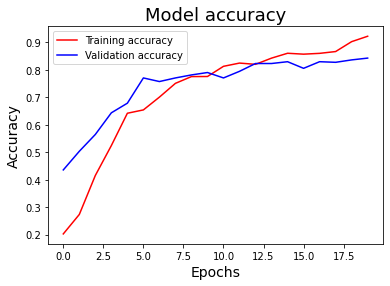

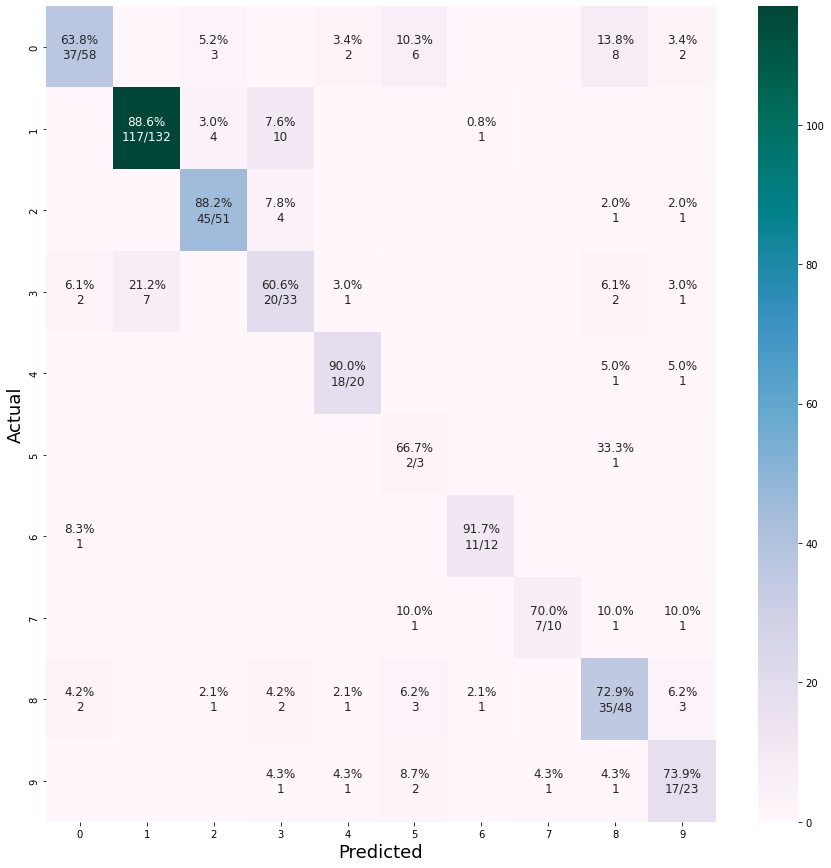

In [18]:
model.evaluate(test_images, test_labels, verbose=2)
print_loss(hist)
predictions = model.predict(test_images)
pred = np.argmax(predictions,axis=1)
cm_analysis(test_labels, pred, range(10), figsize=(15,15), filename='cm_final', annot_kws={"size": 12}, cmap='PuBuGn')